# Setup

In [9]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
from tensorflow.keras import *
from tensorflow.keras.layers import *
from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [46]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#Only keep the chords???
tx = y

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Standardize it? 
tx = (tx-tx.mean())/tx.std()

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Data exploration

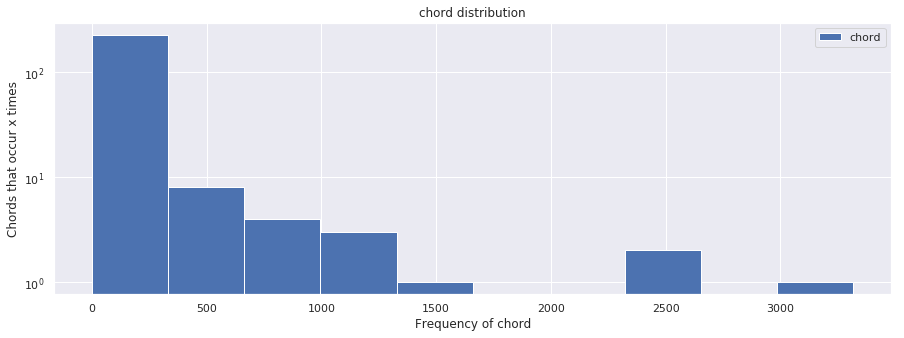

In [12]:
#Count how many times each chord appear
chord_dist = data[['chord']].groupby('chord')['chord'].count()

#Sort them and make them into a dataframe
chord_dist = chord_dist.sort_values(ascending = False)
chord_dist = pd.DataFrame(chord_dist)

#Plot the distribution
ax = chord_dist.plot.hist(figsize = [15,5])
ax.semilogy()
ax.set_xlabel("Frequency of chord")
ax.set_ylabel("Chords that occur x times")
_=ax.set_title("chord distribution")


# Helper Functions

In [13]:
def disp_results(history_object):
    """
    Takes a history object and plots the evolution of the metrics as well as the final scores
    """
    history = history_object
    df = pd.DataFrame({'epochs': history.epoch,
                       'accuracy': history.history['acc'],
                       'validation_accuracy': history.history['val_acc'],
                       'loss': history.history['loss'], 
                       'val_loss': history.history['val_loss']})


    #Plot the the scores on the validation and training sets
    df.plot(x='epochs', y = ['validation_accuracy','accuracy'], figsize=[15,5])
    df.plot(x='epochs', y = ['val_loss','loss'], figsize=[15,5])

    a = history.history['acc'][-1]
    va= history.history['val_acc'][-1]
    l = history.history['loss'][-1]
    vl= history.history['val_loss'][-1]

    print("Final values\nacc\n{}\nvalacc\n{}\nloss\n{}\nvaloss\n{}\n".format(a, va, l, vl))
    
    print(history.model.summary())
    plt.show()

In [36]:
def generate_sequences(train_x, train_y, seq_length):
    """
    Input:
        train_x, train_y: the data we want to transform into sequences
        seq_length: the length of the sequences
    Return:
        lstm_x: a matrix where elements are on the form (sequence, sequence length, features)
        lstm_y: a matrix where elements are on the form (sequence, classes)
    Notes: 
        Does not generate sequences for the last (seq_length - 1) datapoints
        Takes quite a lot of computing with long sequence lengths.
        
        
    """
    #containers for the sequences we generate
    lstm_input = []
    lstm_output = []
    
    for i in range(0, train_x.shape[0] - (seq_length +1)):
        #Create a sequence
        in_data = train_x.iloc[i:seq_length + i].values
        lstm_input.append(in_data)
        
        #Select the chord that would have appeared after the sequence
        out_data = train_y.iloc[seq_length + i].values
        lstm_output.append(out_data) 

    #Convert to arrays
    lstm_x = np.array(lstm_input)
    lstm_y = np.array(lstm_output)
    
    return lstm_x, lstm_y

# Models

In [16]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics):
    """
    A LSTM, a neural network operating on sequences to predict next items in a sequence.
    Needs some data preprocessing to generate sequences
    """
    # Input layers
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2]))) 
    model.add(Dropout(0.3))
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Activation('softmax')) 
    
    #Output layers
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    #Hyperparameters
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [88]:
def lstm2(lstm_x, lstm_y, optimizer, loss, metrics):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True),input_shape=(lstm_x.shape[1],lstm_x.shape[2])))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model



# Train

## Setup

In [26]:
#Define model parameters
optimizer = optimizers.Adam()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
callbacks_list = []  

In [ ]:
#Run this cell only if you want to checkpoint progress
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5',
    monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

callbacks_list = [checkpoint]     

In [ ]:
#Run this cell to load saved weights
#model.load_weights('weights.10-4.13.hdf5')

## Fit

In [89]:
#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#ONLY CHORDS
tx = y

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h1 = history

Train on 20219 samples, validate on 5055 samples
Epoch 1/100
20219/20219 [==============================] - 112s 6ms/step - loss: 3.5707 - acc: 0.1162 - val_loss: 3.6353 - val_acc: 0.0944
Epoch 2/100
20219/20219 [==============================] - 68s 3ms/step - loss: 3.5450 - acc: 0.1242 - val_loss: 3.6391 - val_acc: 0.0944
Epoch 3/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.5398 - acc: 0.1245 - val_loss: 3.6448 - val_acc: 0.0944
Epoch 4/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.5351 - acc: 0.1254 - val_loss: 3.6556 - val_acc: 0.0944
Epoch 5/100
20219/20219 [==============================] - 67s 3ms/step - loss: 3.5320 - acc: 0.1254 - val_loss: 3.6470 - val_acc: 0.0944
Epoch 6/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.5288 - acc: 0.1254 - val_loss: 3.6383 - val_acc: 0.0944
Epoch 7/100
20219/20219 [==============================] - 49s 2ms/step - loss: 3.5242 - acc: 0.1254 - val_loss: 3.6157 - 

20219/20219 [==============================] - 46s 2ms/step - loss: 2.7793 - acc: 0.2782 - val_loss: 3.5218 - val_acc: 0.1687
Epoch 60/100
20219/20219 [==============================] - 46s 2ms/step - loss: 2.7600 - acc: 0.2805 - val_loss: 3.5648 - val_acc: 0.1745
Epoch 61/100
20219/20219 [==============================] - 46s 2ms/step - loss: 2.7394 - acc: 0.2869 - val_loss: 3.5554 - val_acc: 0.1658
Epoch 62/100
20219/20219 [==============================] - 46s 2ms/step - loss: 2.7298 - acc: 0.2885 - val_loss: 3.5463 - val_acc: 0.1608
Epoch 63/100
20219/20219 [==============================] - 46s 2ms/step - loss: 2.7132 - acc: 0.2933 - val_loss: 3.6051 - val_acc: 0.1618
Epoch 64/100
20219/20219 [==============================] - 46s 2ms/step - loss: 2.7049 - acc: 0.2934 - val_loss: 3.5708 - val_acc: 0.1719
Epoch 65/100
20219/20219 [==============================] - 46s 2ms/step - loss: 2.6830 - acc: 0.2978 - val_loss: 3.6096 - val_acc: 0.1656
Epoch 66/100
20219/20219 [==============

In [90]:
#EVERYTHING
#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0'])

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h2 = history

Train on 20219 samples, validate on 5055 samples
Epoch 1/100
20219/20219 [==============================] - 110s 5ms/step - loss: 3.5668 - acc: 0.1174 - val_loss: 3.6233 - val_acc: 0.0944
Epoch 2/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.5350 - acc: 0.1238 - val_loss: 3.6424 - val_acc: 0.0944
Epoch 3/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.5266 - acc: 0.1252 - val_loss: 3.6314 - val_acc: 0.0944
Epoch 4/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.5227 - acc: 0.1250 - val_loss: 3.6284 - val_acc: 0.0944
Epoch 5/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.5147 - acc: 0.1250 - val_loss: 3.6504 - val_acc: 0.0944
Epoch 6/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.5073 - acc: 0.1247 - val_loss: 3.6459 - val_acc: 0.0944
Epoch 7/100
20219/20219 [==============================] - 64s 3ms/step - loss: 3.4985 - acc: 0.1243 - val_loss: 3.6204 - 

20219/20219 [==============================] - 66s 3ms/step - loss: 3.0607 - acc: 0.2072 - val_loss: 3.1803 - val_acc: 0.2006
Epoch 60/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.0614 - acc: 0.2084 - val_loss: 3.2298 - val_acc: 0.1871
Epoch 61/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.0504 - acc: 0.2081 - val_loss: 3.2225 - val_acc: 0.1919
Epoch 62/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.0483 - acc: 0.2091 - val_loss: 3.2538 - val_acc: 0.1812
Epoch 63/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.0356 - acc: 0.2105 - val_loss: 3.2415 - val_acc: 0.1834
Epoch 64/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.0350 - acc: 0.2145 - val_loss: 3.2417 - val_acc: 0.1850
Epoch 65/100
20219/20219 [==============================] - 66s 3ms/step - loss: 3.0435 - acc: 0.2101 - val_loss: 3.1990 - val_acc: 0.1964
Epoch 66/100
20219/20219 [==============

In [91]:
#NO CHORDS
#Load all data
data = pd.read_csv('data/updated_with_R.csv')

#Extract labels
y = data[['chord']]
tx = data.drop(columns=['Unnamed: 0', 'chord'])

#Use one-hot encoding/dummy variabes for categorical values
y = pd.get_dummies(y)
tx = pd.get_dummies(tx)

#Replace Nans with zero, since x*nan = nan
tx = tx.replace(np.nan, 0)

#Split the data into training and test sets
#Since order is important, shuffle = False, but we should probably split on the moments or something similar
train_x, test_x, train_y, test_y = model_selection.train_test_split(tx, y, test_size = 0.1, shuffle = False)

# Generate the sequences for the lstm
lstm_x, lstm_y = generate_sequences(train_x, train_y, 10)

#Generate model
model = lstm2(lstm_x, lstm_y, optimizer, loss, metrics)
    
#Train on it and save metrics at each epoch
history = model.fit(lstm_x,
                    lstm_y,
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.2, 
                    callbacks = callbacks_list)

h3 = history

Train on 20219 samples, validate on 5055 samples
Epoch 1/100
20219/20219 [==============================] - 106s 5ms/step - loss: 3.5675 - acc: 0.1205 - val_loss: 3.6308 - val_acc: 0.0944
Epoch 2/100
20219/20219 [==============================] - 60s 3ms/step - loss: 3.5354 - acc: 0.1228 - val_loss: 3.6367 - val_acc: 0.0944
Epoch 3/100
20219/20219 [==============================] - 60s 3ms/step - loss: 3.5325 - acc: 0.1247 - val_loss: 3.6379 - val_acc: 0.0944
Epoch 4/100
20219/20219 [==============================] - 60s 3ms/step - loss: 3.5240 - acc: 0.1255 - val_loss: 3.6334 - val_acc: 0.0944
Epoch 5/100
20219/20219 [==============================] - 60s 3ms/step - loss: 3.5157 - acc: 0.1246 - val_loss: 3.6406 - val_acc: 0.0944
Epoch 6/100
20219/20219 [==============================] - 60s 3ms/step - loss: 3.5097 - acc: 0.1253 - val_loss: 3.6783 - val_acc: 0.0944
Epoch 7/100
20219/20219 [==============================] - 60s 3ms/step - loss: 3.4869 - acc: 0.1264 - val_loss: 3.6685 - 

20219/20219 [==============================] - 59s 3ms/step - loss: 3.1033 - acc: 0.1936 - val_loss: 3.2756 - val_acc: 0.1739
Epoch 60/100
20219/20219 [==============================] - 59s 3ms/step - loss: 3.0924 - acc: 0.1939 - val_loss: 3.2457 - val_acc: 0.1860
Epoch 61/100
20219/20219 [==============================] - 59s 3ms/step - loss: 3.0918 - acc: 0.1961 - val_loss: 3.2404 - val_acc: 0.1860
Epoch 62/100
20219/20219 [==============================] - 59s 3ms/step - loss: 3.0864 - acc: 0.1974 - val_loss: 3.2389 - val_acc: 0.1869
Epoch 63/100
20219/20219 [==============================] - 59s 3ms/step - loss: 3.0788 - acc: 0.1978 - val_loss: 3.2475 - val_acc: 0.1854
Epoch 64/100
20219/20219 [==============================] - 59s 3ms/step - loss: 3.0691 - acc: 0.2021 - val_loss: 3.2595 - val_acc: 0.1846
Epoch 65/100
20219/20219 [==============================] - 59s 3ms/step - loss: 3.0692 - acc: 0.2025 - val_loss: 3.2120 - val_acc: 0.1877
Epoch 66/100
20219/20219 [==============

# Results

### Primitive feature selection
What is best. Only chords, all features, all except chords?

Using only the chord feature
Final values
acc
0.4022948711460496
valacc
0.14025717109412278
loss
2.2165435983823487
valoss
4.454794151351431

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_113 (LSTM)              (None, 10, 128)           104448    
_________________________________________________________________
dropout_72 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_115 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_73 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 75)                2475      


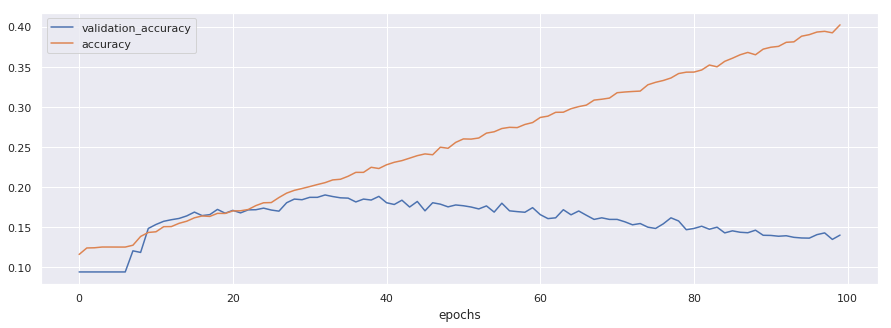

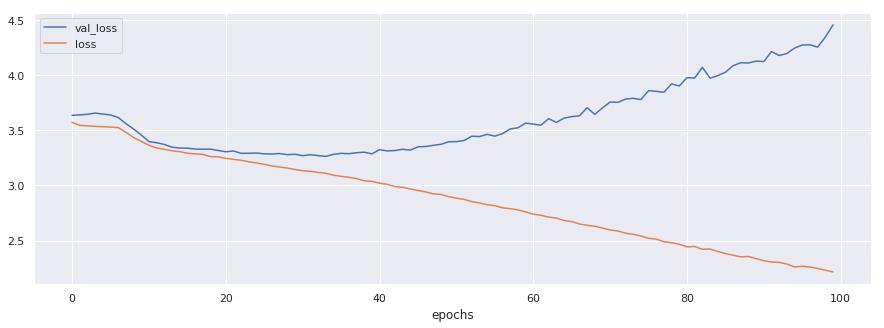

Using all features
Final values
acc
0.24091201345564095
valacc
0.19920870424142342
loss
2.9095368462197535
valoss
3.2357819291651544

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_116 (LSTM)              (None, 10, 128)           239104    
_________________________________________________________________
dropout_74 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_118 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_75 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 75)                2475      
Total pa

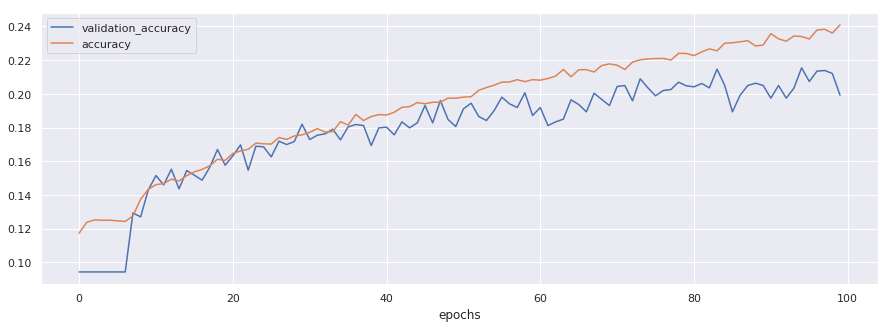

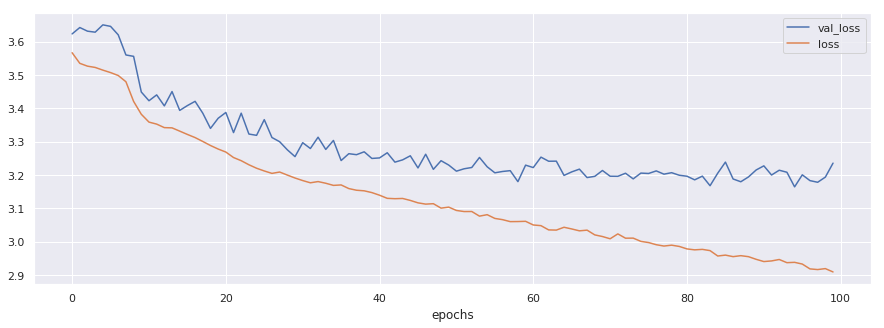

Using all features except chords
Final values
acc
0.2260250259494621
valacc
0.2025717111652612
loss
2.95196132054049
valoss
3.2145481655317054

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 10, 128)           200704    
_________________________________________________________________
dropout_76 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 10, 128)           98816     
_________________________________________________________________
lstm_121 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_77 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 75)                2475     

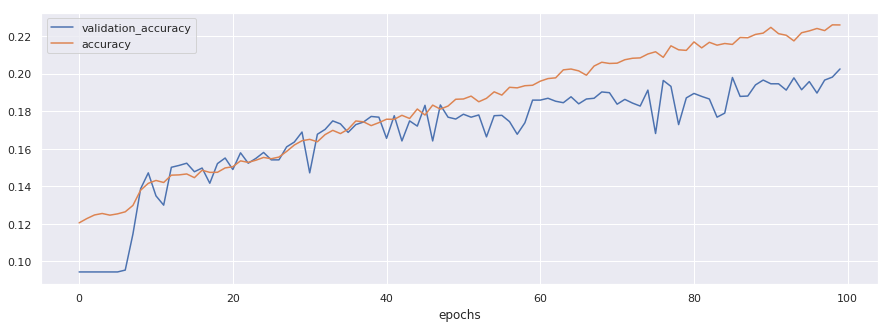

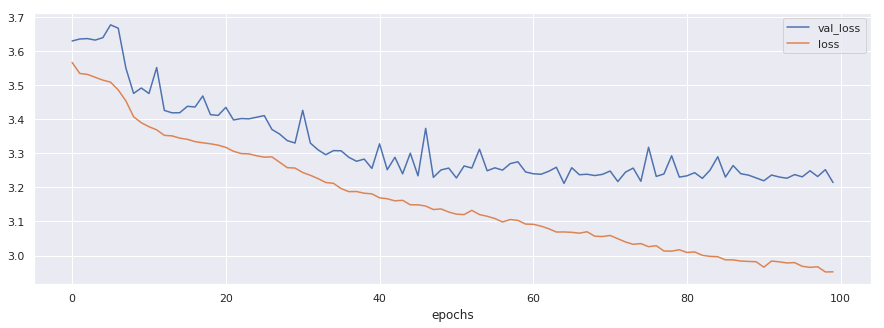

In [92]:
print("Using only the chord feature")
disp_results(h1)

print("Using all features")
disp_results(h2)

print("Using all features except chords")
disp_results(h3)


### Sequence lengths
Testing on sequence lenghts 5, 10, 20, 40, 80
Conclusions: Best with 10, marginal differences overall, significantly faster training with smaller sequences.

Final values
acc
0.18487645131149047
valacc
0.1522127405980036
loss
3.2899261492638048
valoss
3.598195571846422

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

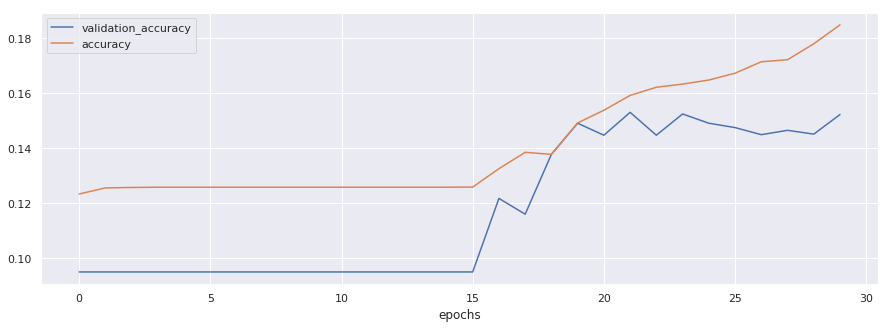

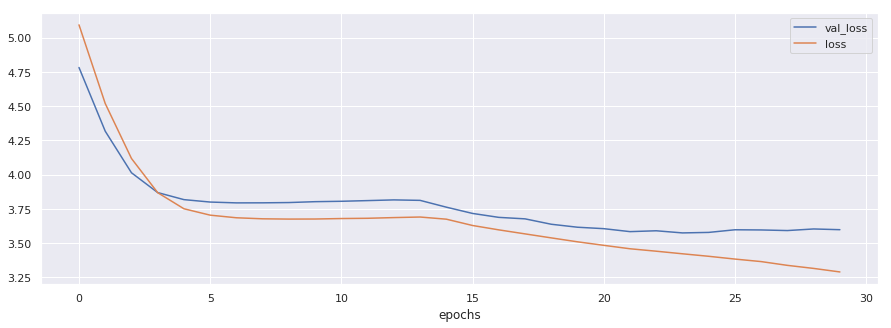

Final values
acc
0.21727047144922962
valacc
0.15839618893133928
loss
3.141557002150391
valoss
3.5978817542236254

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

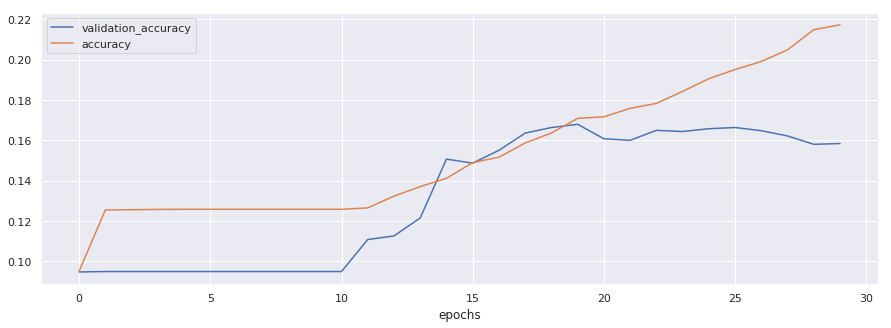

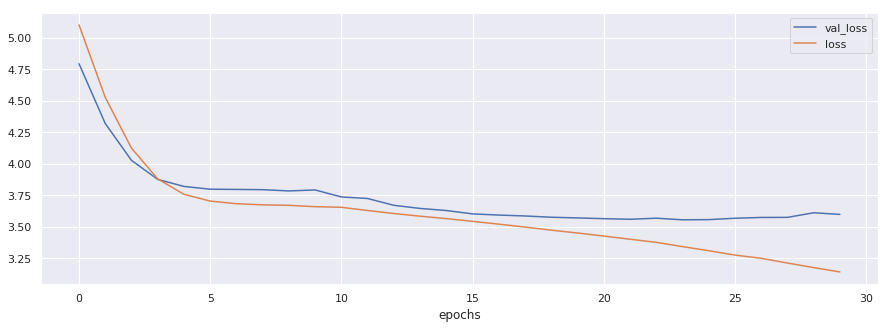

Final values
acc
0.16413464401260933
valacc
0.15031771248796802
loss
3.4155722475255472
valoss
3.5944106556102335

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
___________________________

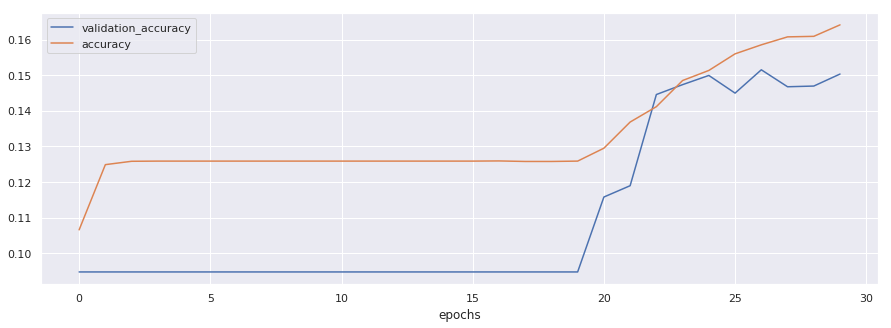

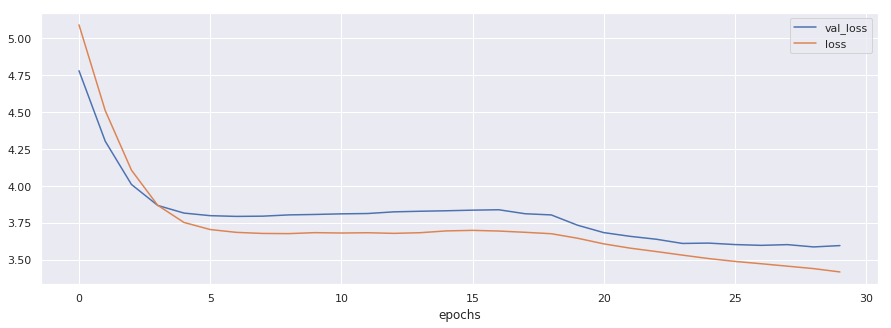

Final values
acc
0.18761800656312266
valacc
0.15441176470588236
loss
3.345946513408815
valoss
3.6128885901410173

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
____________________________

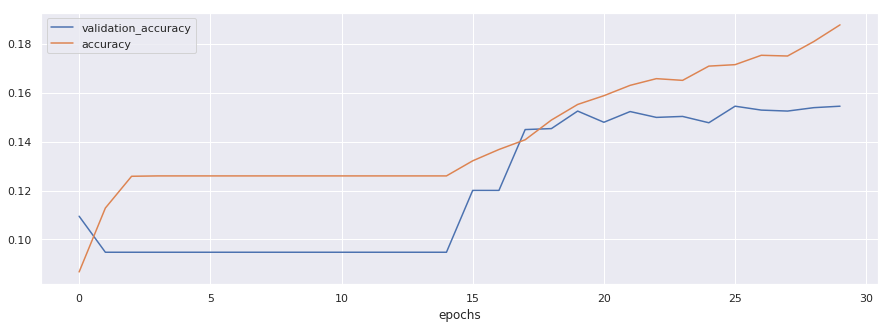

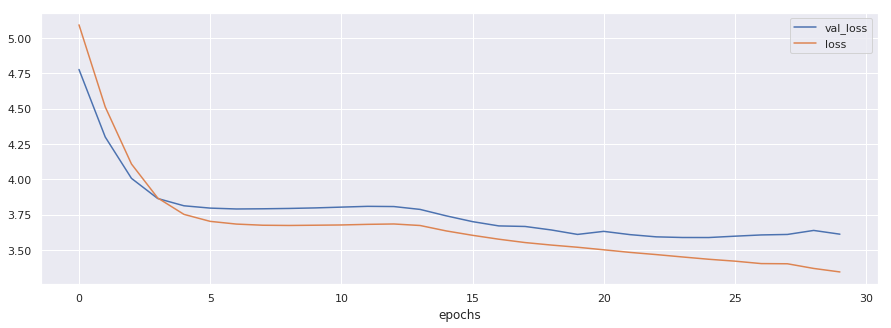

Final values
acc
0.14904946749235512
valacc
0.1429140127388535
loss
3.556054708363702
valoss
3.6760981447377783

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 160, 256)          513024    
_________________________________________________________________
dropout_15 (Dropout)         (None, 160, 256)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 160, 512)          1574912   
_________________________________________________________________
dropout_16 (Dropout)         (None, 160, 512)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_____________________________

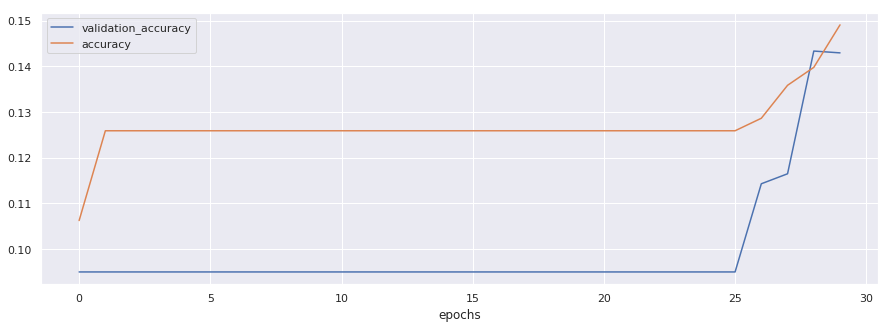

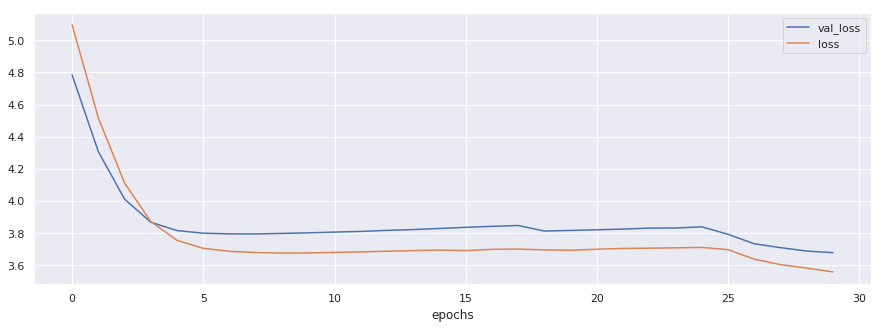

In [16]:
disp_results(h1)
disp_results(h2)
disp_results(h3)
disp_results(h4)
disp_results(h5)


In [28]:
#Save weights
h1.model.save("h1.hdf5")
h2.model.save("h2.hdf5")
h3.model.save("h3.hdf5")
h4.model.save("h4.hdf5")
h5.model.save("h5.hdf5")

### Training for 100 epochs using only the chords feature


Final values
acc
0.7754342432530879
valacc
0.11055974594571373
loss
0.8889608065602798
valoss
5.647335171178959

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 10, 256)           513024    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 256)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 10, 512)           1574912   
_________________________________________________________________
dropout_19 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_____________________________

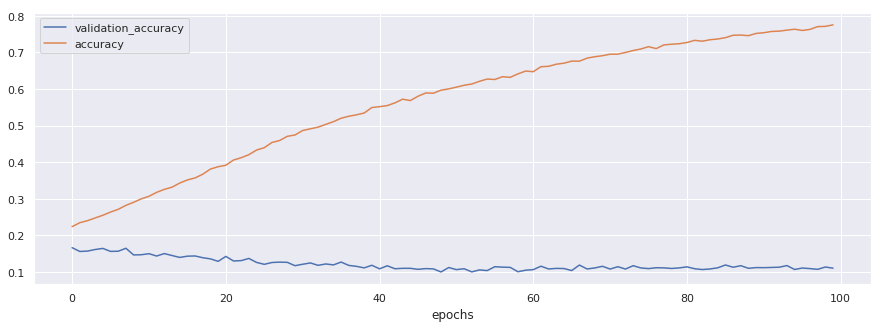

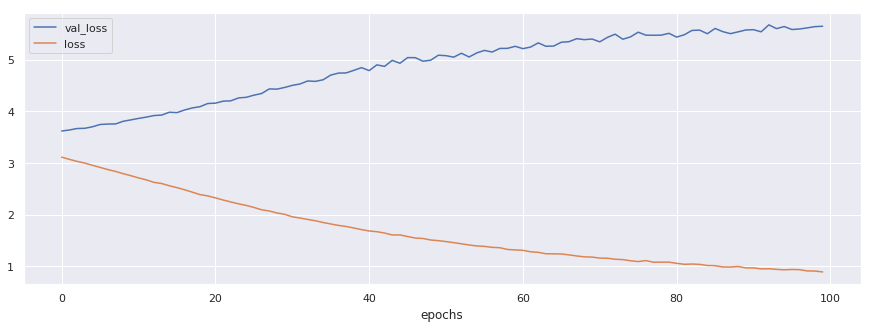

In [31]:
disp_results(h6)
h6.model.save("h6.hdf5")

### Training for 100 epochs using ALL features


Final values
acc
0.6240694788608598
valacc
0.1129416435034136
loss
1.402275422358927
valoss
5.05821556191257

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 256)           800768    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 512)           1574912   
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
________________________________

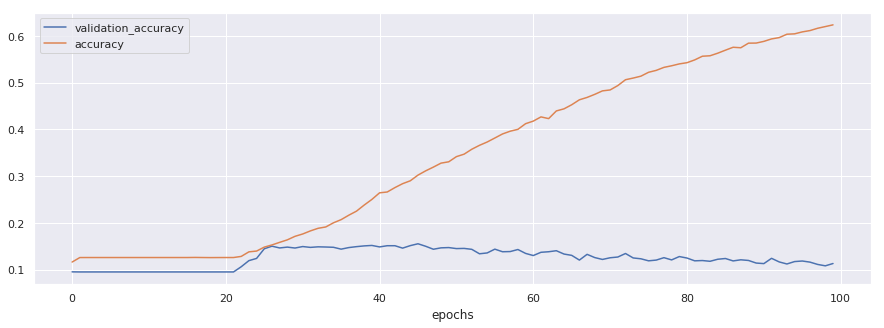

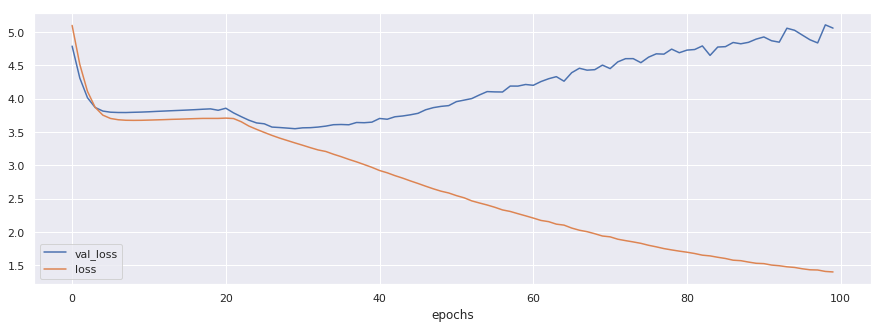

In [9]:
disp_results(h7)
h7.model.save("h7.hdf5")